In [15]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
%matplotlib inline
import numpy as np
import time
import json
import urllib
import codecs
import folium

> #### Import the data with valid rows and preview the first five rows to understand the data we're working with.

In [2]:
raw_data = pd.read_csv('delivery_startup.csv')[:60196]
raw_data.rename(columns={' customer_price_usd ': 'customer_price_usd'}, inplace=True)
raw_data.head()

,customer_price_usd,courier_price,day_of_week_local,market,num_items,pickup_zipcode,distance_pickup_to_dropoff_km,purchase_price,avg_courier_rating,status,...,dropoff_zipcode,rating_by_customer,purchase_fee,vehicle_type,purchase_tip,credit_applied,date_created_local,rating_by_courier,date_created,auto_assigned
0,$9.50,6.38,sat,sf,8.0,94102.0,2.001679,79.16,4.8,dropoff_complete,...,94105.0,5,7.12,bicycle,18.96,0.0,2014-03-01 00:01:44.538420-08:00,5,0.001209,False
1,$7.00,4.50,sat,sf,3.0,94110.0,0.688776,9.72,4.8,dropoff_complete,...,94110.0,5,0.87,bicycle,4.15,0.0,2014-03-01 00:27:58.717530-08:00,5,0.019429,False
2,$7.00,4.50,sat,sf,2.0,94110.0,0.746792,9.65,4.7,dropoff_complete,...,94110.0,5,0.48,bicycle,0.81,0.0,2014-03-01 07:07:48.391376-08:00,5,0.005421,False
3,$7.50,4.88,sat,sf,2.0,94109.0,0.992590,24.74,5,dropoff_complete,...,94115.0,None,1.24,car,4.87,0.0,2014-03-01 08:03:37.135812-08:00,5,0.002513,False
4,$8.99,5.99,sat,sf,3.0,94114.0,0.539742,11.90,5,dropoff_complete,...,94131.0,None,0.60,bicycle,4.10,0.0,2014-03-01 08:04:30.205173-08:00,5,0.003127,False


In [3]:
#Finding rows and columns
print(raw_data.shape)

(60196, 22)


In [4]:
print (raw_data.isnull().sum())

customer_price_usd                 0
courier_price                      1
day_of_week_local                  0
market                             0
num_items                          0
pickup_zipcode                   855
distance_pickup_to_dropoff_km      0
purchase_price                     0
avg_courier_rating                 0
status                             0
duration                           0
reassigned                         0
dropoff_zipcode                   12
rating_by_customer                 0
purchase_fee                       0
vehicle_type                       0
purchase_tip                       0
credit_applied                     0
date_created_local                 0
rating_by_courier                  0
date_created                       0
auto_assigned                      0
dtype: int64


<div class="alert alert-block alert-info">
<b>Missing data:</b> We are missing some pickup zipcodes. I will need to take this into consideration while doing delivery location analysis later. 
I will not remove these null values while doing delivery time and delivery prices analysis since it will remove some information on other metrics for my analysis.
</div>

> I also want to check to make sure we don't have any duplicate rows.

In [5]:
#Searching for duplicate rows
num_duplicates = 0
for i in raw_data.duplicated():
    if i == True:
        num_duplicates += 1
print ('Number of Duplicates:',num_duplicates)

Number of Duplicates: 0


- There are no duplicates so we move on to the next step.

> I would like take a look at what type of data we are working with.

In [6]:
raw_data.dtypes

customer_price_usd                object
courier_price                    float64
day_of_week_local                 object
market                            object
num_items                        float64
pickup_zipcode                   float64
distance_pickup_to_dropoff_km    float64
purchase_price                   float64
avg_courier_rating                object
status                            object
duration                         float64
reassigned                       float64
dropoff_zipcode                  float64
rating_by_customer                object
purchase_fee                     float64
vehicle_type                      object
purchase_tip                     float64
credit_applied                   float64
date_created_local                object
rating_by_courier                 object
date_created                     float64
auto_assigned                     object
dtype: object

<div class="alert alert-block alert-info">
<b>Data Type Issues:</b> There are some problems with the data types of customer_price_usd, zipcodes and date_created_local which we would like them to be float64, int and datetime stamps data type respectively. In this case, we need to convert these data types in the later analysis while needed.
</div>

- Firstly, I want to convert the delivery timestamps to datetime formats so that I can better analyze when the orders being created. 
- Secondly, I'll also add another columns about then month, day, hour and day of week of order created so that I can analyze the difference between weekday and weekend deliveries. 
- And I will also convert delivery duration to unit miniutes for better comparision.

In [7]:
raw_data['duration'] = pd.to_timedelta(raw_data['duration'], unit='s')
raw_data['date_created_local'] = pd.to_datetime(raw_data['date_created_local'])

- We have the data starting from 2014-03-01 to 2014-06-01

In [8]:
print (raw_data.date_created_local.min())
print (raw_data.date_created_local.max())

2014-03-01 08:01:44.538420
2014-06-01 06:55:20.534675


In [9]:
raw_data['delivery_month'] = raw_data['date_created_local'].dt.month
raw_data['delivery_day'] = raw_data['date_created_local'].dt.day
raw_data['delivery_hour'] = raw_data['date_created_local'].dt.hour
raw_data['day_of_week'] = raw_data['date_created_local'].dt.dayofweek

In [10]:
raw_data.head()

,customer_price_usd,courier_price,day_of_week_local,market,num_items,pickup_zipcode,distance_pickup_to_dropoff_km,purchase_price,avg_courier_rating,status,...,purchase_tip,credit_applied,date_created_local,rating_by_courier,date_created,auto_assigned,delivery_month,delivery_day,delivery_hour,day_of_week
0,$9.50,6.38,sat,sf,8.0,94102.0,2.001679,79.16,4.8,dropoff_complete,...,18.96,0.0,2014-03-01 08:01:44.538420,5,0.001209,False,3,1,8,5
1,$7.00,4.50,sat,sf,3.0,94110.0,0.688776,9.72,4.8,dropoff_complete,...,4.15,0.0,2014-03-01 08:27:58.717530,5,0.019429,False,3,1,8,5
2,$7.00,4.50,sat,sf,2.0,94110.0,0.746792,9.65,4.7,dropoff_complete,...,0.81,0.0,2014-03-01 15:07:48.391376,5,0.005421,False,3,1,15,5
3,$7.50,4.88,sat,sf,2.0,94109.0,0.992590,24.74,5,dropoff_complete,...,4.87,0.0,2014-03-01 16:03:37.135812,5,0.002513,False,3,1,16,5
4,$8.99,5.99,sat,sf,3.0,94114.0,0.539742,11.90,5,dropoff_complete,...,4.10,0.0,2014-03-01 16:04:30.205173,5,0.003127,False,3,1,16,5


## Analysis
### Number of Deliveries


> Next I'll create separate columns for day and hour so that I can better analyze our deliveries over time. I also want to create a column for the day of the week so that I can analyze the difference between weekday and weekend deliveries.

In [11]:
#Defining function to label days as a weekday or weekend
def week(x):
    if x['day_of_week'] in range(5):
        return 'Weekday'
    else:
        return 'Weekend'

#Adding a separate column for the categorization of weekday or weekend
raw_data['weekday_weekend'] = raw_data.apply(week, axis = 1)

#### Number of Deliveries Over Months
> First I want to look at how many deliveries we've completed over the months.

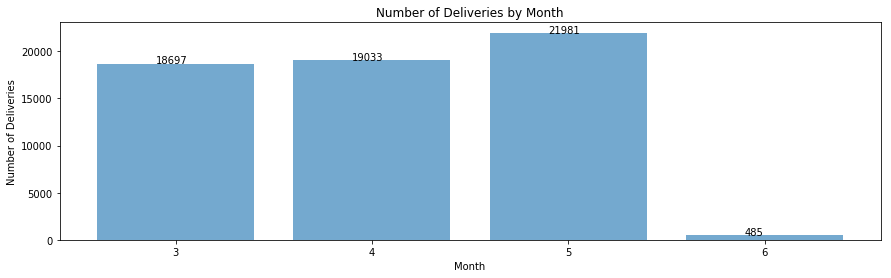

In [12]:
df_monthly_deliveries = raw_data.groupby(['delivery_month']).count()['customer_price_usd']
#Creating a grid to arrange the plots
the_grid = GridSpec(2, 1)
the_grid.update(left=0.05, right=1, hspace=0.5)
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(the_grid[0])
ax1.bar(df_monthly_deliveries.index, df_monthly_deliveries.values, color = '#74a9cf')
plt.xticks(range(3, 7, 1))
#plt.xticks(range(24))
#ax1.set_xlim(xmax = 23)
plt.title('Number of Deliveries by Month')
plt.ylabel('Number of Deliveries')
plt.xlabel('Month')
for i, v in enumerate(df_monthly_deliveries.values):
    plt.text(i + 2.9 , v + 1, str(v))

We separate the data set by month:

In [13]:
data_March = raw_data[raw_data['delivery_month'] == 3]
data_April = raw_data[raw_data['delivery_month'] == 4]
data_May = raw_data[raw_data['delivery_month'] == 5]

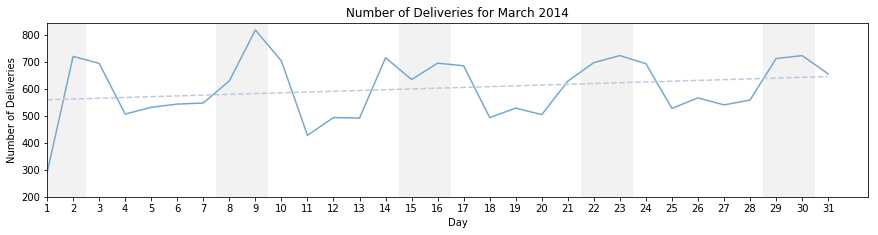

In [16]:
#Creating series of deliveries by day, using column customer_price_usd as a reference for different deliveries every day
deliveries_by_day_March = data_March.groupby(['delivery_day']).count()['customer_price_usd']
#Creating a grid to arrange the plots
the_grid = GridSpec(2, 1)
the_grid.update(left=0.05, right=1, hspace=0.5)
#Plotting deliveries by day
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(deliveries_by_day_March.index, deliveries_by_day_March.values, color = '#74a9cf')

#Calculating trendline
z = np.polyfit(deliveries_by_day_March.index, deliveries_by_day_March.values, 1)
p = np.poly1d(z)

#Plotting trendline
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(deliveries_by_day_March.index,p(deliveries_by_day_March.index),'r-', color = '#bdc9e1', linestyle = 'dashed')

#Highlighting weekends
plt.axvspan(0.5, 2.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(7.5, 9.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(14.5, 16.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(21.5, 23.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(28.5, 30.5, facecolor = 'k', alpha = 0.05)
#Modifying chart
plt.xticks(deliveries_by_day_March.index)
ax1.set_ylim(ymin = 200)
ax1.set_xlim(xmin = 1)
plt.title('Number of Deliveries for March 2014')
plt.ylabel('Number of Deliveries')
plt.xlabel('Day')

plt.show()

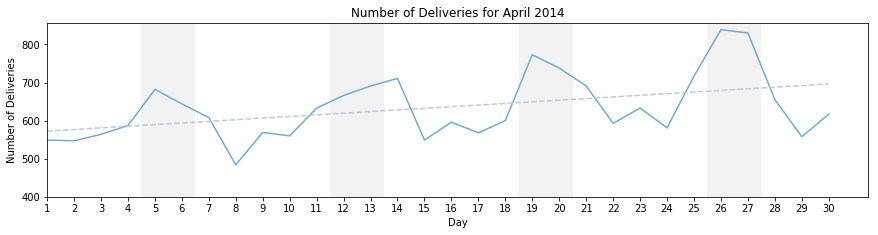

In [17]:
#Creating series of deliveries by day
deliveries_by_day_April = data_April.groupby(['delivery_day']).count()['customer_price_usd']
#Creating a grid to arrange the plots
the_grid = GridSpec(2, 1)
the_grid.update(left=0.05, right=1, hspace=0.5)
#Plotting deliveries by day
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(deliveries_by_day_April.index, deliveries_by_day_April.values, color = '#74a9cf')

#Calculating trendline
z = np.polyfit(deliveries_by_day_April.index, deliveries_by_day_April.values, 1)
p = np.poly1d(z)

#Plotting trendline
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(deliveries_by_day_April.index,p(deliveries_by_day_April.index),'r-', color = '#bdc9e1', linestyle = 'dashed')

#Highlighting weekends
plt.axvspan(4.5, 6.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(11.5, 13.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(18.5, 20.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(25.5, 27.5, facecolor = 'k', alpha = 0.05)

#Modifying chart
plt.xticks(deliveries_by_day_April.index)
ax1.set_ylim(ymin = 400)
ax1.set_xlim(xmin = 1)
plt.title('Number of Deliveries for April 2014')
plt.ylabel('Number of Deliveries')
plt.xlabel('Day')

plt.show()

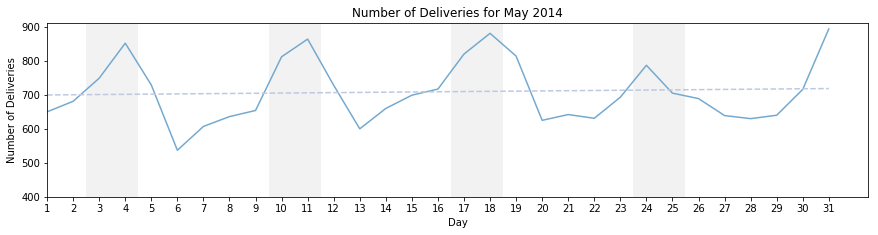

In [18]:
#Creating series of deliveries by day
deliveries_by_day_May = data_May.groupby(['delivery_day']).count()['customer_price_usd']
#Creating a grid to arrange the plots
the_grid = GridSpec(2, 1)
the_grid.update(left=0.05, right=1, hspace=0.5)
#Plotting deliveries by day
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(deliveries_by_day_May.index, deliveries_by_day_May.values, color = '#74a9cf')

#Calculating trendline
z = np.polyfit(deliveries_by_day_May.index, deliveries_by_day_May.values, 1)
p = np.poly1d(z)

#Plotting trendline
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(deliveries_by_day_May.index,p(deliveries_by_day_May.index),'r-', color = '#bdc9e1', linestyle = 'dashed')

#Highlighting weekends
plt.axvspan(2.5, 4.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(9.5, 11.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(16.5, 18.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(23.5, 25.5, facecolor = 'k', alpha = 0.05)

#Modifying chart
plt.xticks(deliveries_by_day_May.index)
ax1.set_ylim(ymin = 400)
ax1.set_xlim(xmin = 1)
plt.title('Number of Deliveries for May 2014')
plt.ylabel('Number of Deliveries')
plt.xlabel('Day')

plt.show()

- From the chart above we can see that deliveries have been trending up through each month. We also see peaks are the Sundays of each week. (The weekends in each month have been highlighted in grey on the graphs.)


- In March and April, deliveries decrease as coming from Sunday to Monday and slowly increase from Monday to Tuesday, and gets to a small peak on Wednesday. I wonder if this is because cutomers are more tired in the middle of a week and tend to call for a delivery when they want something. Deliveries have peaks on Sundays because customers tend to leave their errands for Sunday or are more likely to order-in on this rest day. In this case, we should have more people working on Wednesday and Sundays in order to handle large number of deliveries.


> Next I want to analyze which times of the day receive the most orders. I will split this analysis into weekdays and weekends since customers will have different schedules depending on the day of the week.

#### Number of Deliveries during a day
Second I want to look at how the number of deliveries change throughout a day separated by weekday and weekend.

In [19]:
#Creating series of deliveries by hour for weekdays and weekends
weekday_hourly_deliveries = raw_data[raw_data['weekday_weekend'] == 'Weekday'].groupby(['delivery_hour']).count()['customer_price_usd']
weekend_hourly_deliveries = raw_data[raw_data['weekday_weekend'] == 'Weekend'].groupby(['delivery_hour']).count()['customer_price_usd']

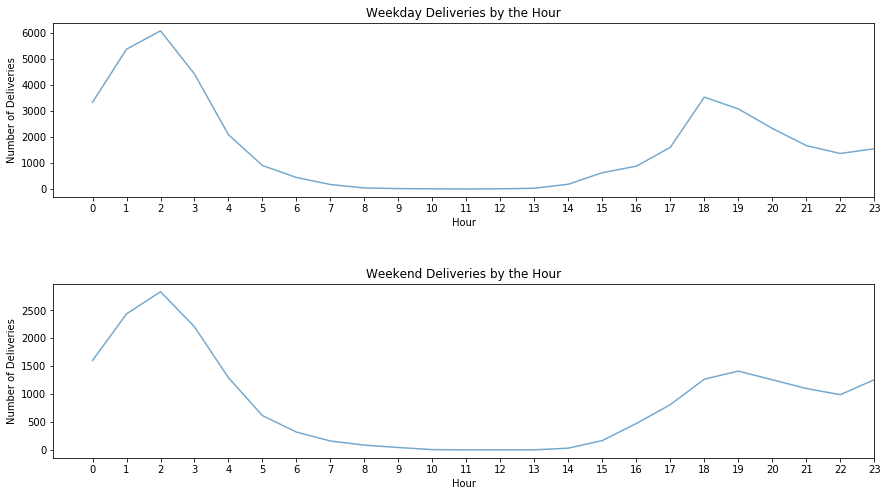

In [20]:
#Creating a grid to arrange the plots
the_grid = GridSpec(2, 1)
the_grid.update(left=0.05, right=1, hspace=0.5)

#Plotting deliveries by hour for weekdays
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(weekday_hourly_deliveries.index, weekday_hourly_deliveries.values, color = '#74a9cf')
plt.xticks(range(24))
ax1.set_xlim(xmax = 23)
plt.title('Weekday Deliveries by the Hour')
plt.ylabel('Number of Deliveries')
plt.xlabel('Hour')

#Plotting deliveries by hour for weekends
ax2 = fig.add_subplot(the_grid[1])
ax2.plot(weekend_hourly_deliveries.index, weekend_hourly_deliveries.values, color = '#74a9cf')
plt.xticks(range(24))
ax2.set_xlim(xmax = 23)
plt.title('Weekend Deliveries by the Hour')
plt.ylabel('Number of Deliveries')
plt.xlabel('Hour')

plt.show()

- It seems that for both weekdays and weekends we see our largest peak around midnight, and the second peak is around dinner. We want to make sure we have enough couriers available to complete these deliveries during these times. 


### Average Delivery Time
#### Next I want to take a look at our average delivery time

In [21]:
#Converting delivery times from timedelta to float
raw_data.duration = raw_data.duration/pd.Timedelta(minutes=1)

General Statistics of Delivery Times
count    60196.000000
mean        43.320369
std         15.876634
min          1.111192
25%         32.417293
50%         41.139020
75%         51.676998
max        370.646673
Name: duration, dtype: float64


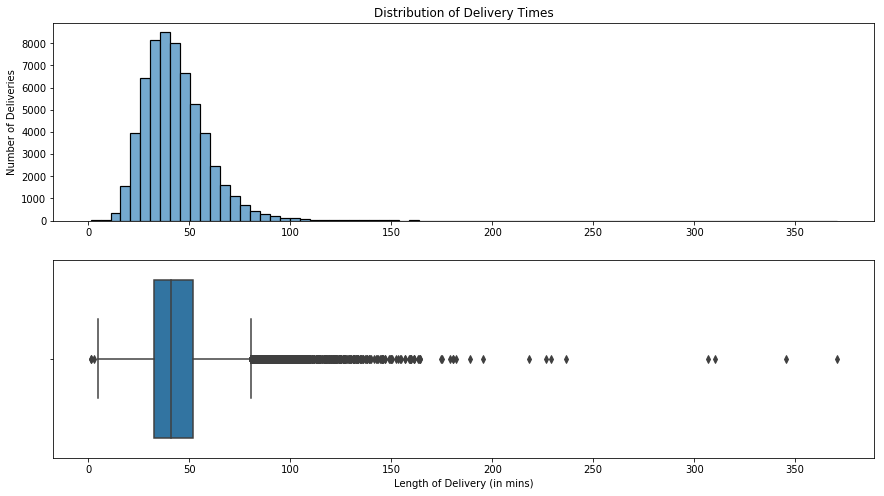

In [22]:
#Descriptive statistics of delivery times
print ('General Statistics of Delivery Times')
print (raw_data.duration.describe())

#Creating a grid to arrange the plots
the_grid = GridSpec(2, 1)
the_grid.update(left=0.05, right=1, hspace=0.2)

#Creating series of delivery times
delivery_times = raw_data.duration

#Plotting histogram of average delivery times 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.hist(delivery_times,75,color = '#74a9cf', edgecolor='black', linewidth=1.2)
plt.title('Distribution of Delivery Times')
plt.ylabel('Number of Deliveries')

#Plotting boxplot of delivery times with outliers
ax2 = fig.add_subplot(the_grid[1])
sns.boxplot(raw_data.duration)
plt.xlabel('Length of Delivery (in mins)')

plt.show()

<div class="alert alert-block alert-info">
<b>Outliers:</b> Our average delivery time for the month is around 43 minutes. It looks like we have some deliveries that were ridiculously long - the longest being 370 minutes. We are going to identify these outliers so that we can investigate them further.
</div>

In [23]:
#Calculating outliers and display list. Remove outliers from further analysis
raw_data['delivery_outlier'] = abs(raw_data.duration - raw_data.duration.mean()) > 1.96*raw_data.duration.std()
print ('Number of Delivery Time Outliers')
print (raw_data[raw_data['delivery_outlier'] == True].count()['delivery_outlier'])

Number of Delivery Time Outliers
2334


I have calculated 2334 outliers for this dataset. I will to remove these outliers from my analysis so that they do not skew the results.

I am particularily interested in the delivery time that took 370 minutes. I have pulled it out so that we can investigate the problem further and take action to prevent something similar from happening in the future.

In [24]:
raw_data[raw_data['duration'] == 370.646673]

,customer_price_usd,courier_price,day_of_week_local,market,num_items,pickup_zipcode,distance_pickup_to_dropoff_km,purchase_price,avg_courier_rating,status,...,date_created_local,rating_by_courier,date_created,auto_assigned,delivery_month,delivery_day,delivery_hour,day_of_week,weekday_weekend,delivery_outlier
56193,$6.75,4.6,mon,sf,6.0,94109.0,0.658683,30.0,4.9,dropoff_complete,...,2014-05-27 00:00:32.733767,5,0.000378,False,5,27,0,1,Weekday,True


In [25]:
#Finding outlier range
raw_data[raw_data['delivery_outlier'] == True][raw_data['duration'] > 41].min()['duration']

74.43926746666666

- We may also want to look into any delivery that took over 74 minutes to see if there was an issue and how we may improve our delivery times.

In [26]:
#df will be new data frame taking out the outilers
df = raw_data[raw_data['delivery_outlier'] == False]

In [27]:
df_duration_by_day = df.groupby(['day_of_week_local']).mean()['duration']
df_duration_by_day = df_duration_by_day.reindex(["mon", "tue", "wed", "thu", "fri", "sat", "sun"])

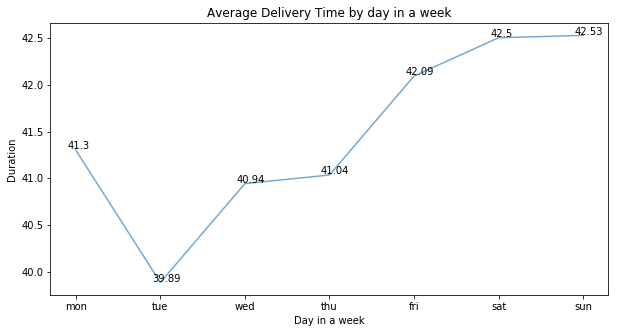

In [28]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(df_duration_by_day.index, df_duration_by_day.values, color = '#74a9cf')
plt.title("Average Delivery Time by day in a week")
plt.xlabel("Day in a week")
plt.ylabel("Duration")
for i, v in enumerate(df_duration_by_day.values):
    plt.text(i - 0.1, v + 0.01, str(v.round(2)))

- We could see that Tuesday takes the shortest delivery time, while Saturday and Sunday take the longest time for delivery.

In [29]:
df_duration_rating = df[df['rating_by_customer'] != 'None']

In [30]:
df_duration_rating['rating'] = df_duration_rating['rating_by_customer'].astype('int')

In [31]:
df_duration_rating.groupby(['rating']).mean()['duration']

rating
1    47.391859
2    46.570296
3    47.343994
4    45.324574
5    40.814742
Name: duration, dtype: float64

- The highest rating 5 has average delivery time about 40.8 minutes

#### Next I will analyze how our average delivery time have changed over March, April and May.

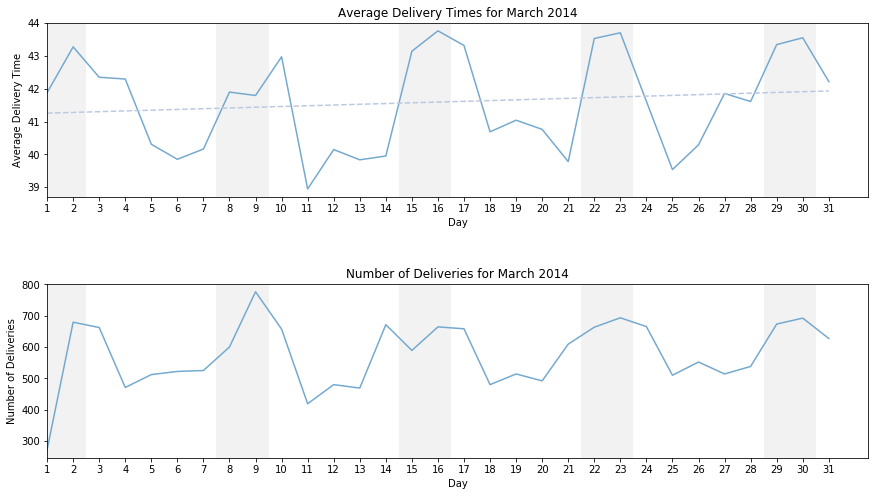

In [32]:
#Creating a series of average delivery times through the month
deliveries_by_day = df[df['delivery_month']==3].groupby(['delivery_day']).count()['customer_price_usd']
avg_delivery_times_by_day = df[df['delivery_month']==3].groupby(['delivery_day']).mean()['duration']

#Creating a grid to arrange the plots
the_grid = GridSpec(2, 1)
the_grid.update(left=0.05, right=1, hspace=0.5)

#Plotting average delivery times through the month
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(avg_delivery_times_by_day.index, avg_delivery_times_by_day.values, color = '#74a9cf')

#Calculating trendline
z = np.polyfit(avg_delivery_times_by_day.index, avg_delivery_times_by_day.values, 1)
p = np.poly1d(z)

#Plotting trendline
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(avg_delivery_times_by_day.index,p(avg_delivery_times_by_day.index),'r-', 
         color = '#bdc9e1', linestyle = 'dashed')

#Modifying the chart
plt.xticks(avg_delivery_times_by_day.index)
ax1.set_xlim(xmin = 1)
plt.title('Average Delivery Times for March 2014')
plt.ylabel('Average Delivery Time')
plt.xlabel('Day')

#Highlighting weekends
plt.axvspan(0.5, 2.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(7.5, 9.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(14.5, 16.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(21.5, 23.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(28.5, 30.5, facecolor = 'k', alpha = 0.05)

#Plotting deliveries by day
ax2 = fig.add_subplot(the_grid[1])
ax2.plot(deliveries_by_day.index, deliveries_by_day.values, color = '#74a9cf')
plt.xticks(deliveries_by_day.index)
ax2.set_xlim(xmin = 1)
plt.title('Number of Deliveries for March 2014')
plt.ylabel('Number of Deliveries')
plt.xlabel('Day')

#Highlighting weekends
plt.axvspan(0.5, 2.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(7.5, 9.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(14.5, 16.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(21.5, 23.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(28.5, 30.5, facecolor = 'k', alpha = 0.05)

plt.show()

In [33]:
print ('Average Delivery Time Line Equation')
print ('y = %.6fx + (%.6f)'%(z[0],z[1]))

Average Delivery Time Line Equation
y = 0.022521x + (41.232199)


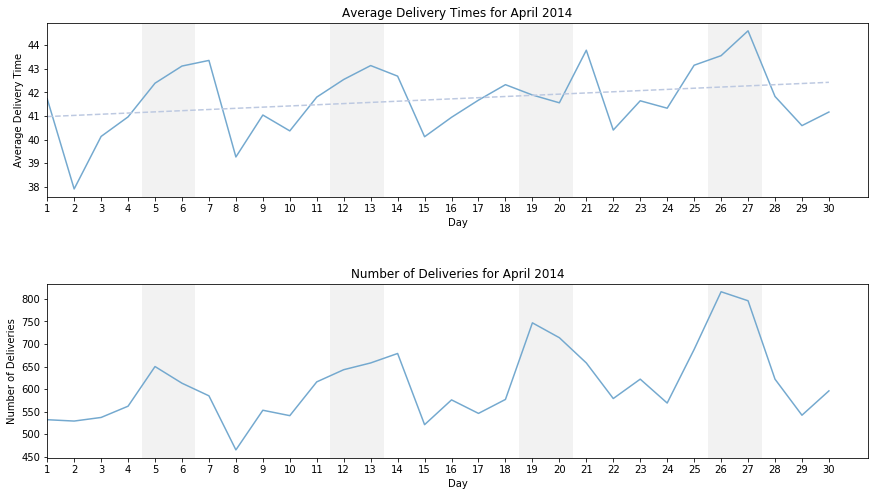

In [34]:
#Creating a series of average delivery times through the month
deliveries_by_day = df[df['delivery_month']==4].groupby(['delivery_day']).count()['customer_price_usd']
avg_delivery_times_by_day = df[df['delivery_month']==4].groupby(['delivery_day']).mean()['duration']

#Creating a grid to arrange the plots
the_grid = GridSpec(2, 1)
the_grid.update(left=0.05, right=1, hspace=0.5)

#Plotting average delivery times through the month
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(avg_delivery_times_by_day.index, avg_delivery_times_by_day.values, color = '#74a9cf')

#Calculating trendline
z = np.polyfit(avg_delivery_times_by_day.index, avg_delivery_times_by_day.values, 1)
p = np.poly1d(z)

#Plotting trendline
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(avg_delivery_times_by_day.index,p(avg_delivery_times_by_day.index),'r-', 
         color = '#bdc9e1', linestyle = 'dashed')

#Modifying the chart
plt.xticks(avg_delivery_times_by_day.index)
ax1.set_xlim(xmin = 1)
plt.title('Average Delivery Times for April 2014')
plt.ylabel('Average Delivery Time')
plt.xlabel('Day')

#Highlighting weekends
plt.axvspan(4.5, 6.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(11.5, 13.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(18.5, 20.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(25.5, 27.5, facecolor = 'k', alpha = 0.05)

#Plotting deliveries by day
ax2 = fig.add_subplot(the_grid[1])
ax2.plot(deliveries_by_day.index, deliveries_by_day.values, color = '#74a9cf')
plt.xticks(deliveries_by_day.index)
ax2.set_xlim(xmin = 1)
plt.title('Number of Deliveries for April 2014')
plt.ylabel('Number of Deliveries')
plt.xlabel('Day')

#Highlighting weekends
plt.axvspan(4.5, 6.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(11.5, 13.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(18.5, 20.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(25.5, 27.5, facecolor = 'k', alpha = 0.05)

plt.show()

In [35]:
print ('Average Delivery Time Line Equation')
print ('y = %.6fx + (%.6f)'%(z[0],z[1]))

Average Delivery Time Line Equation
y = 0.050048x + (40.921629)


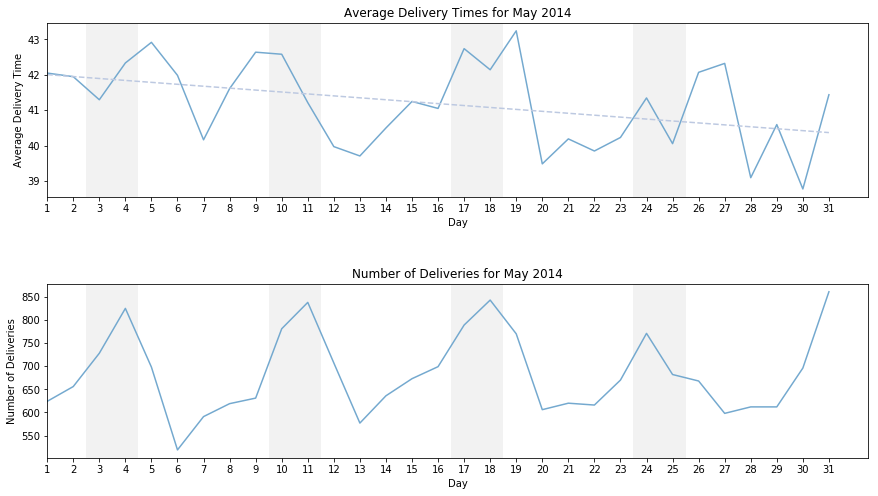

In [36]:
#Creating a series of average delivery times through the month
deliveries_by_day = df[df['delivery_month']==5].groupby(['delivery_day']).count()['customer_price_usd']
avg_delivery_times_by_day = df[df['delivery_month']==5].groupby(['delivery_day']).mean()['duration']

#Creating a grid to arrange the plots
the_grid = GridSpec(2, 1)
the_grid.update(left=0.05, right=1, hspace=0.5)

#Plotting average delivery times through the month
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(avg_delivery_times_by_day.index, avg_delivery_times_by_day.values, color = '#74a9cf')

#Calculating trendline
z = np.polyfit(avg_delivery_times_by_day.index, avg_delivery_times_by_day.values, 1)
p = np.poly1d(z)

#Plotting trendline
ax1 = fig.add_subplot(the_grid[0])
ax1.plot(avg_delivery_times_by_day.index,p(avg_delivery_times_by_day.index),'r-', 
         color = '#bdc9e1', linestyle = 'dashed')

#Modifying the chart
plt.xticks(avg_delivery_times_by_day.index)
ax1.set_xlim(xmin = 1)
plt.title('Average Delivery Times for May 2014')
plt.ylabel('Average Delivery Time')
plt.xlabel('Day')

#Highlighting weekends
plt.axvspan(2.5, 4.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(9.5, 11.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(16.5, 18.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(23.5, 25.5, facecolor = 'k', alpha = 0.05)

#Plotting deliveries by day
ax2 = fig.add_subplot(the_grid[1])
ax2.plot(deliveries_by_day.index, deliveries_by_day.values, color = '#74a9cf')
plt.xticks(deliveries_by_day.index)
ax2.set_xlim(xmin = 1)
plt.title('Number of Deliveries for May 2014')
plt.ylabel('Number of Deliveries')
plt.xlabel('Day')

#Highlighting weekends
plt.axvspan(2.5, 4.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(9.5, 11.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(16.5, 18.5, facecolor = 'k', alpha = 0.05)
plt.axvspan(23.5, 25.5, facecolor = 'k', alpha = 0.05)

plt.show()

In [37]:
print ('Average Delivery Time Line Equation')
print ('y = %.6fx + (%.6f)'%(z[0],z[1]))

Average Delivery Time Line Equation
y = -0.054574x + (42.057166)


- What is great is that our overall average delivery times have stayed consistent through the month of May, even with our increasing number of deliveries. The average delivery time has even decreased slightly (difficult to tell on the chart, but it is a slope of -0.05).

- However, as the number of deliveries increases through the week, our average delivery times increase as well. We may not have enough couriers to react to the increased delivery needs. We will want to look into hiring more couriers, or providing a larger incentive, as the number of deliveries increases through the week so that we can decrease our average delivery times.

#### Let's take a closer look at how average delivery times differ on the weekdays and weekends.

In [38]:
print ('General Statistics of Delivery Times for Weekdays')
print (df[df['weekday_weekend'] == 'Weekday']['duration'].describe())
print ("")
print ('General Statistics of Delivery Times for Weekends')
print (df[df['weekday_weekend'] == 'Weekend']['duration'].describe())

General Statistics of Delivery Times for Weekdays
count    38340.000000
mean        41.129276
std         12.680815
min         12.203325
25%         31.600526
50%         40.004743
75%         49.734518
max         74.434716
Name: duration, dtype: float64

General Statistics of Delivery Times for Weekends
count    19522.000000
mean        42.481009
std         12.532572
min         12.226971
25%         33.104865
50%         41.470102
75%         51.232153
max         74.436985
Name: duration, dtype: float64


- The average delivery time for the weekend is 42.48 minutes, which is slightly higher than the average delivery time for the weekday at 41.13 minutes

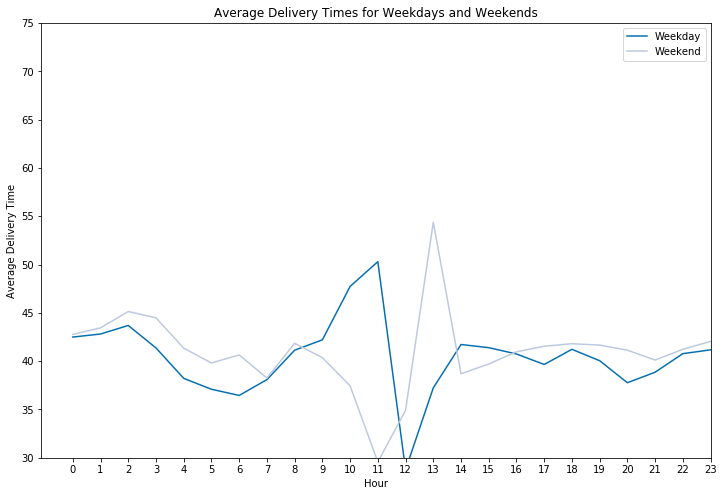

In [39]:
#Creating series of average delivery times by hour for weekdays and weekends
avg_weekday_delivery_times = df[df['weekday_weekend'] == 'Weekday'].groupby(['delivery_hour']).mean()['duration']
avg_weekend_delivery_times = df[df['weekday_weekend'] == 'Weekend'].groupby(['delivery_hour']).mean()['duration']

#Plotting average delivery times by hour for weekdays and weekends
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
ax1.plot(avg_weekday_delivery_times.index, avg_weekday_delivery_times.values, color = '#0570b0', label = 'Weekday')
ax1.plot(avg_weekend_delivery_times.index, avg_weekend_delivery_times.values, color = '#bdc9e1', label = 'Weekend')

#Modifying the chart
plt.xticks(range(24))
ax1.set_xlim(xmax = 23)
ax1.set_ylim(ymin = 30, ymax = 75)
plt.title('Average Delivery Times for Weekdays and Weekends')
plt.ylabel('Average Delivery Time')
plt.xlabel('Hour')
ax1.legend()

plt.show()

- Where we see a peak in average delivery times on the weekend we see a drop on the weekdays. More people are up later on the weekends, which probably results in more orders. Again we may not have enough couriers at these late night hours to respond to the number of orders being placed, which is resulting in the longer delivery times.

### Most Popular Pickup and Dropoff Locations

In [40]:
# The neighborhoods in San Francisco
neighborhoodSF = {
    '91480': 'Mecca',
    '94010': 'Burlingame',
    '94014': 'Daly City',
    '94017': 'Daly City',
    '94019': 'Half Moon Bay',
    '94085': 'Sunnyvale',
    '94101': 'Mckinnon',
    '94102': 'Hayes Valley/Tenderloin/North of Market',
    '94103': 'South of Market',
    '94104': 'Lone Mountain',
    '94105': 'Mission District',
    '94107': 'Potrero Hill',
    '94108': 'Chinatown',
    '94109': 'Polk/Russian Hill (Nob Hill)',
    '94110': 'Inner Mission/Bernal Heights',
    '94111': 'Sunset District',
    '94112': 'Ingelside-Excelsior/Crocker-Amazon',
    '94114': 'Castro/Noe Valley',
    '94115': 'Western Addition/Japantown',
    '94116': 'Parkside/Forest Hill',
    '94117': 'Haight-Ashbury',
    '94118': 'Inner Richmond',
    '94121': 'Outer Richmond',
    '94122': 'Sunset',
    '94123': 'Marina',
    '94124': 'Bayview-Hunters Point',
    '94126': 'Pacific Heights',
    '94127': 'St. Francis Wood/Miraloma/West Portal',
    '94129': 'Presidio Heights',
    '94131': 'Twin Peaks-Glen Park',
    '94132': 'Lake Merced',
    '94133': 'North Beach/Chinatown',
    '94134': 'Visitacion Valley/Sunnydale',
    '94142': 'Russian Hill',
    '94143': 'Parnassus Heights',
    '94158': 'Mission Bay',
    '94199': 'Bayview-Hunters Point',
    '94539': 'Fremont',
    '94903': 'San Rafael',
    '94939': 'Larkspur',
    '94501': 'Alameda',
    '95105': 'Mission',
    '95404': 'Santa Rosa'
    }

In [41]:
# While analyzing the delivery locations, we drop off NA zipcodes from the df
df_zip = df.dropna()

In [42]:
df_zip['pickup_zipcode'] = df_zip['pickup_zipcode'].astype('int64').astype('str')
df_zip['dropoff_zipcode'] = df_zip['dropoff_zipcode'].astype('int64').astype('str')
pickup_neighborhood = []
for i in df_zip.pickup_zipcode:
    pickup_neighborhood.append(neighborhoodSF[i])
dropoff_neighborhood = []
for i in df_zip.dropoff_zipcode:
    dropoff_neighborhood.append(neighborhoodSF[i])
df_zip['pickup_neighborhood'] = pickup_neighborhood
df_zip['dropoff_neighborhood'] = dropoff_neighborhood

Text(0.5,0,'Pickup Location')

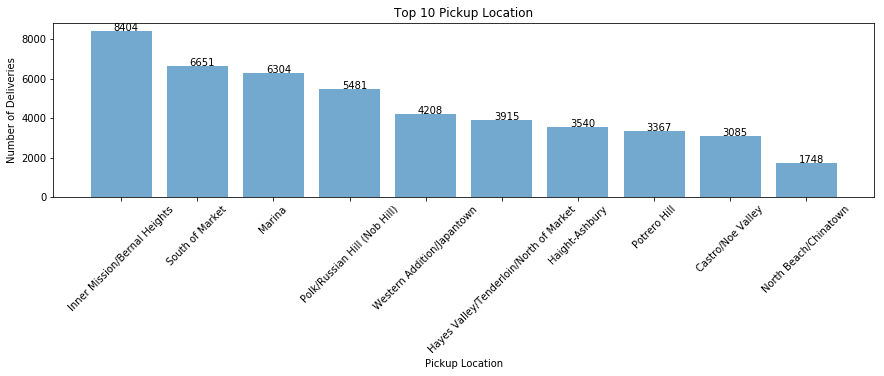

In [43]:
top_pickup = df_zip.groupby(['pickup_neighborhood']).count()['customer_price_usd'].sort_values(ascending = False)[:10]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.bar(top_pickup.index, top_pickup.values, color = '#74a9cf')
plt.xticks(rotation=45)
for i, v in enumerate(top_pickup.values):
    plt.text(i - 0.1, v + 0.01, str(v))
plt.title('Top 10 Pickup Location')
plt.ylabel('Number of Deliveries')
plt.xlabel('Pickup Location')

Text(0.5,0,'Dropoff Location')

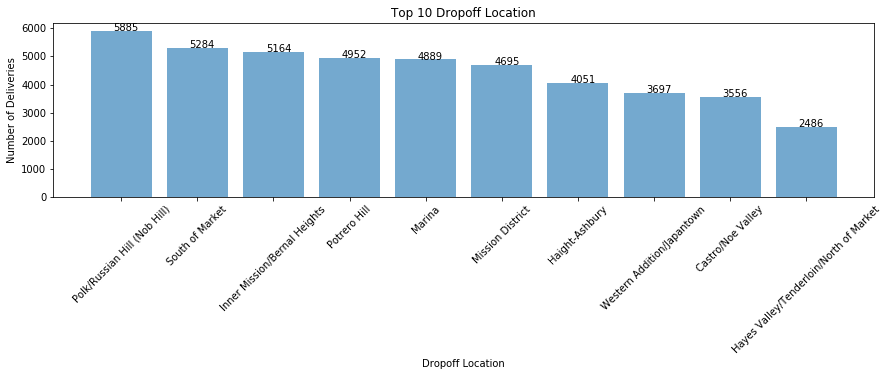

In [44]:
top_dropoff = df_zip.groupby(['dropoff_neighborhood']).count()['customer_price_usd'].sort_values(ascending = False)[:10]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(the_grid[0])
ax1.bar(top_dropoff.index, top_dropoff.values, color = '#74a9cf')
plt.xticks(rotation=45)
for i, v in enumerate(top_dropoff.values):
    plt.text(i - 0.1, v + 0.01, str(v))
    
plt.title('Top 10 Dropoff Location')
plt.ylabel('Number of Deliveries')
plt.xlabel('Dropoff Location')

In [45]:
#Plot map with the color represents the number of deliveries in each area
import folium
df_pickup = df_zip.groupby(['pickup_zipcode']).count()
df_dropoff = df_zip.groupby(['dropoff_zipcode']).count()
df_pickup.reset_index(inplace=True)
df_dropoff.reset_index(inplace=True)
def create_map(table, zips, mapped_feature, add_text = ''):
    # reading of the updated GeoJSON file
    la_geo = r'San Francisco ZIP Codes.json'
    # initiating a Folium map with LA's longitude and latitude
    m = folium.Map(location = [37.76, -122.45], zoom_start = 12)
    # creating a choropleth map
    m.choropleth(
        geo_data = la_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.zip_code',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'YlGnBu',
        legend_name = add_text + ' Location Across SF'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = add_text + '_map.html')

In [46]:
create_map(df_pickup, 'pickup_zipcode', 'customer_price_usd', 'Pickup')
create_map(df_dropoff, 'dropoff_zipcode', 'customer_price_usd', 'Dropoff')

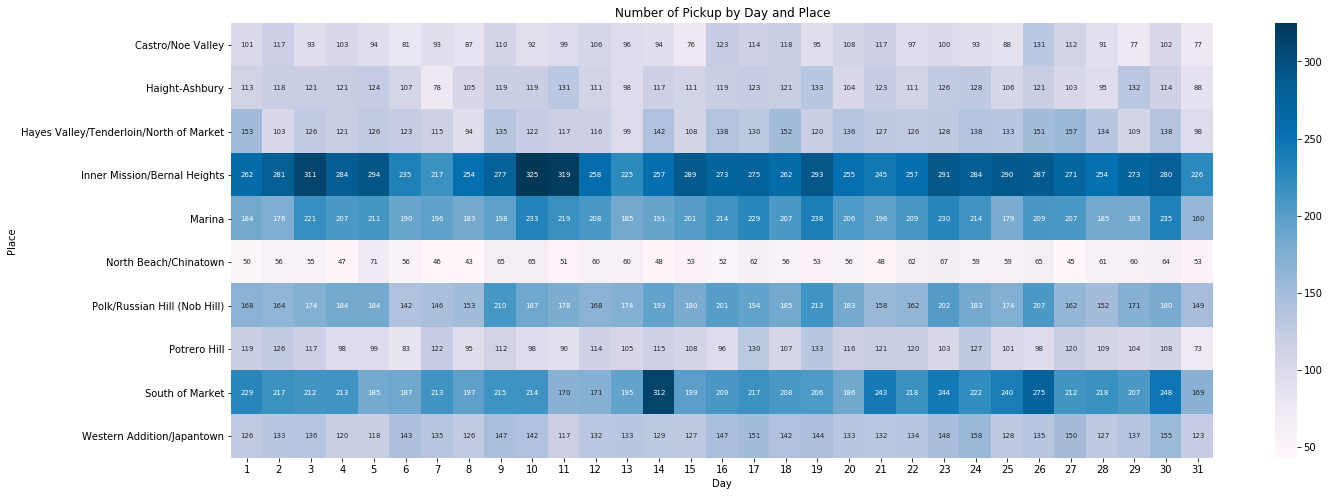

In [47]:
#Creating pivot table of most popular pick up locations by day
place_table = pd.pivot_table(df_zip[df_zip['pickup_neighborhood'].isin(top_pickup.index)], 
                             values = ['customer_price_usd'], index = ['pickup_neighborhood'], 
                             columns = ['delivery_day'], aggfunc = 'count')

#Plotting heatmap of most popular pick up locations by day
plt.figure(figsize=(22,8))
sns.heatmap(place_table['customer_price_usd'], annot = True, annot_kws = {'size': 7}, fmt = 'g', cmap = 'PuBu')
plt.title('Number of Pickup by Day and Place')
plt.xlabel('Day')
plt.ylabel('Place')

plt.show()

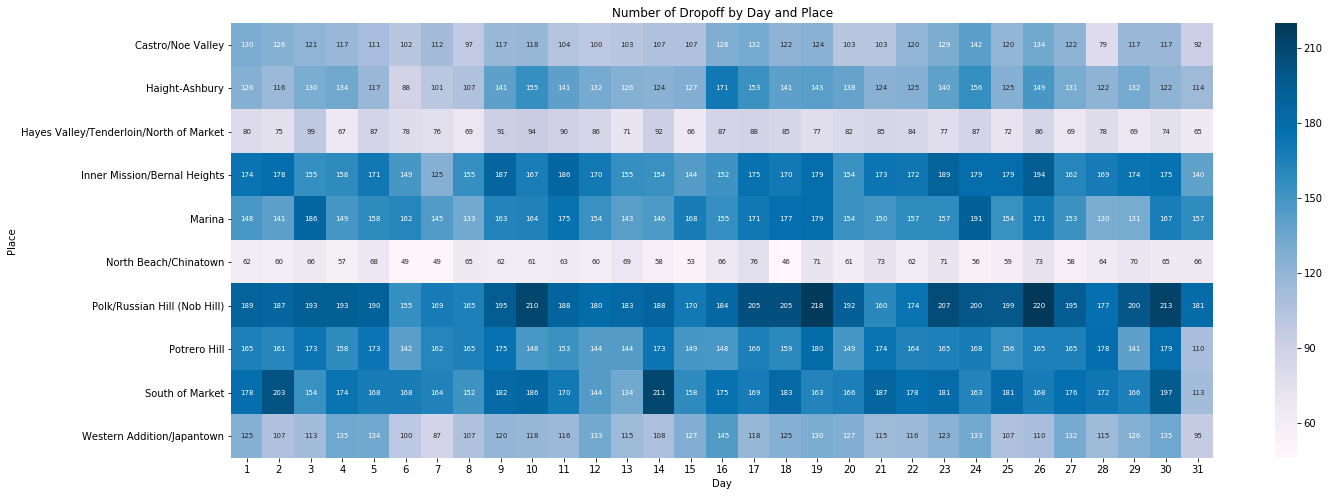

In [48]:
#Creating pivot table of most popular drop off locations by day
place_table = pd.pivot_table(df_zip[df_zip['dropoff_neighborhood'].isin(top_pickup.index)], 
                             values = ['customer_price_usd'], index = ['dropoff_neighborhood'], 
                             columns = ['delivery_day'], aggfunc = 'count')

#Plotting heatmap of most popular drop off locations by day
plt.figure(figsize=(22,8))
sns.heatmap(place_table['customer_price_usd'], annot = True, annot_kws = {'size': 7}, fmt = 'g', cmap = 'PuBu')
plt.title('Number of Dropoff by Day and Place')
plt.xlabel('Day')
plt.ylabel('Place')

plt.show()

In [49]:
# Creat a heat map to show most popular delivery routes
df_heatmap = df_zip.groupby(['pickup_neighborhood', 'dropoff_neighborhood']).count()['customer_price_usd'].sort_values(ascending = False)[:20]

In [50]:
df_heatmap = df_heatmap.reset_index()

In [51]:
df_heatmap.columns = ['pickup', 'dropoff', 'numbers']

In [52]:
df_heatmap

,pickup,dropoff,numbers
0,Marina,Marina,2863
1,Inner Mission/Bernal Heights,Inner Mission/Bernal Heights,2656
2,Polk/Russian Hill (Nob Hill),Polk/Russian Hill (Nob Hill),1708
3,South of Market,South of Market,1342
4,Inner Mission/Bernal Heights,Castro/Noe Valley,1333
5,Haight-Ashbury,Haight-Ashbury,1260
6,Potrero Hill,Potrero Hill,1243
7,Western Addition/Japantown,Western Addition/Japantown,1175
8,South of Market,Potrero Hill,1139
9,Marina,Polk/Russian Hill (Nob Hill),1069


In [53]:
df_heatmap_draw = df_heatmap.pivot('pickup', 'dropoff', 'numbers')

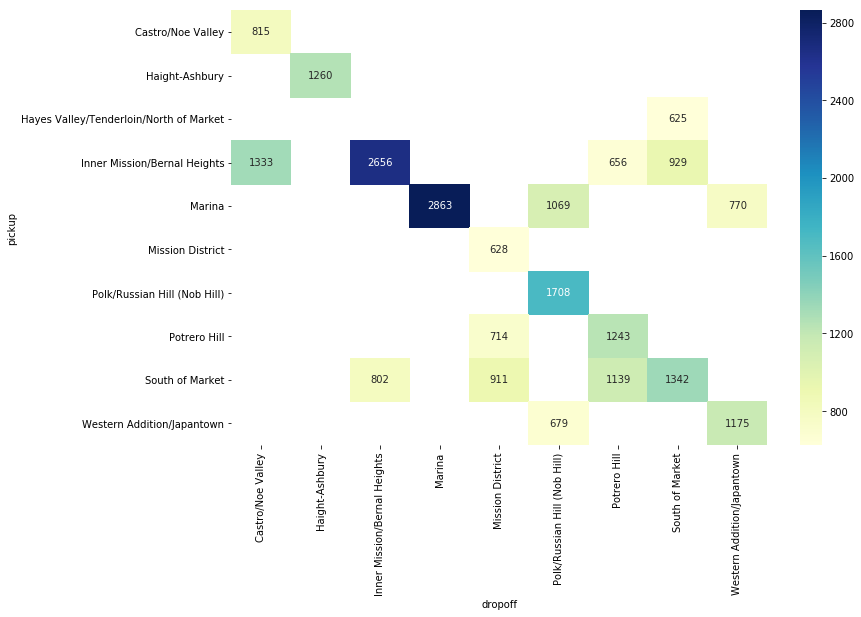

In [54]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(df_heatmap_draw, cmap = "YlGnBu", annot=True, fmt="g")
plt.show()

### Price Analysis

In [55]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [56]:
#Convert the data type of customer_price_usd to float numbers
priceFloat = []
for i in df['customer_price_usd']:
    try:
        priceFloat.append(float(i.replace('$', '').replace(' ', '')))
    except:
        priceFloat.append(i.replace('$', ''))
        pass

In [57]:
#drop off none value points and negative points
df['price'] = priceFloat
df = df[df['price'] != '#VALUE!']
df = df[df['price'] != '(9.00)']
df['price'].astype(float).describe()

count    57860.000000
mean         9.269203
std          2.891253
min          6.500000
25%          7.250000
50%          8.500000
75%         10.500000
max         41.000000
Name: price, dtype: float64

- Average delivery price is about $9.27. 

In [58]:
df['delivery_price'] = df['price'].astype('float')

In [59]:
#Explore the relationship betweeen delivery price, distance and duration.
delivery_model = ols("""delivery_price ~ distance_pickup_to_dropoff_km
                                        + duration
                                        """, data=df).fit()
delivery_model_summary = delivery_model.summary()
delivery_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         delivery_price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                 5.681e+04
Date:                Wed, 16 Jan 2019   Prob (F-statistic):               0.00
Time:                        21:48:15   Log-Likelihood:            -1.1210e+05
No. Observations:               57860   AIC:                         2.242e+05
Df Residuals:                   57857   BIC:                         2.242e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         6.1231      0.024    255.156      0.000       6.076       6.170
distance_pickup_to_dropoff_km     1.6847      0.005    306.867      0.000       1.674       1.695
duration                          0.0068      0.001     11.356      0.000       0.006       0.008
==============================================================================
Omnibus:                    44054.638   Durbin-Watson:                   1.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1207066.783
Skew:                           3.446   Prob(JB):                         0.00
Kurtosis:                      24.288   Cond. No.                         150.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- R-square is 0.663 which means 66.3% of delivery prices could be explained as a function of distance between pickup to dropoff and duration: delivery_price = 6.1231 + 1.6847distance + 0.0068duration

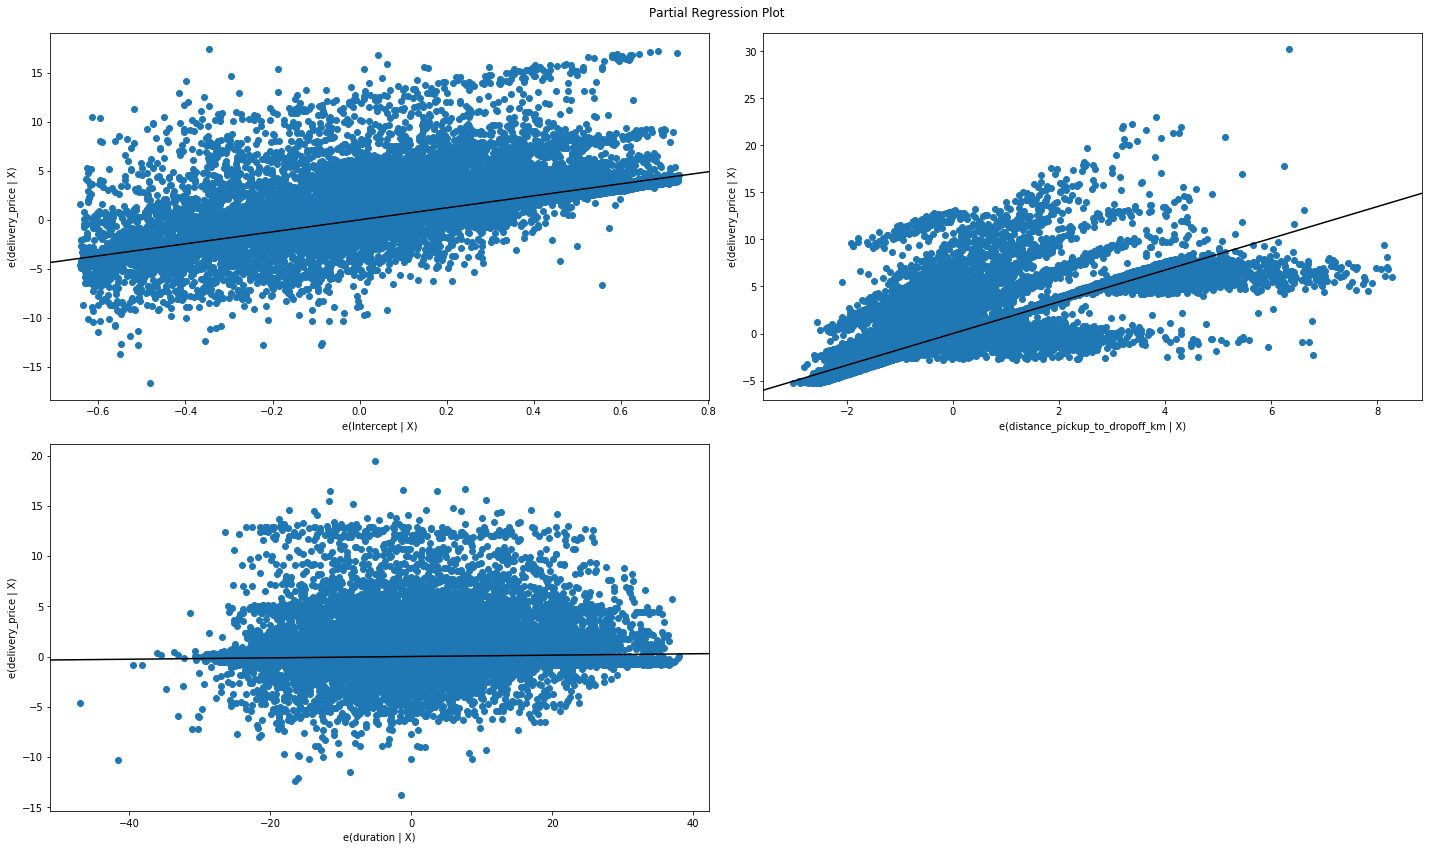

In [60]:
fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(delivery_model, fig=fig)

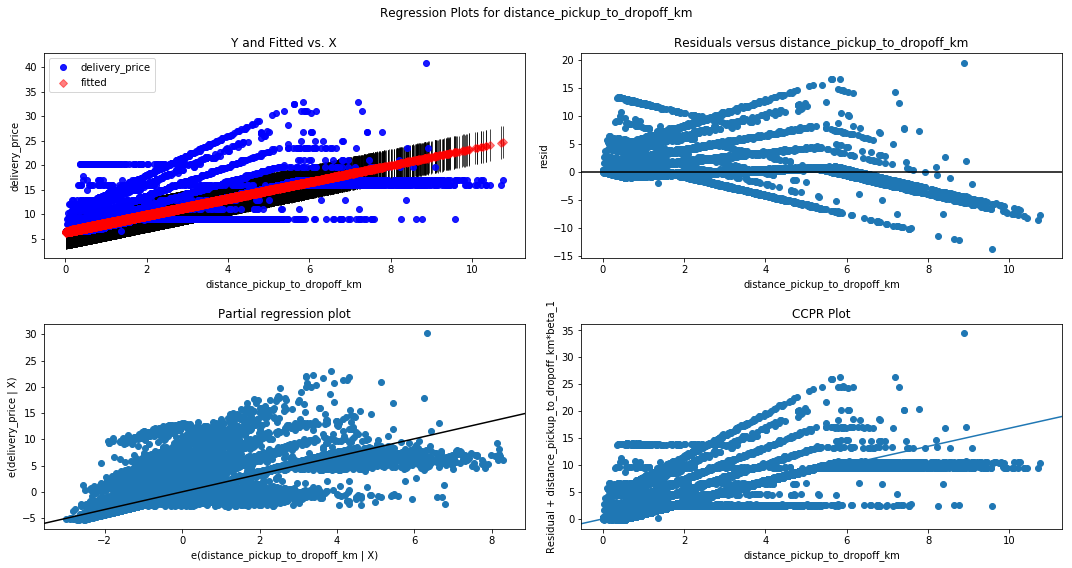

In [61]:
# This produces our four regression plots for delivery prices
fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(delivery_model, "distance_pickup_to_dropoff_km", fig=fig)

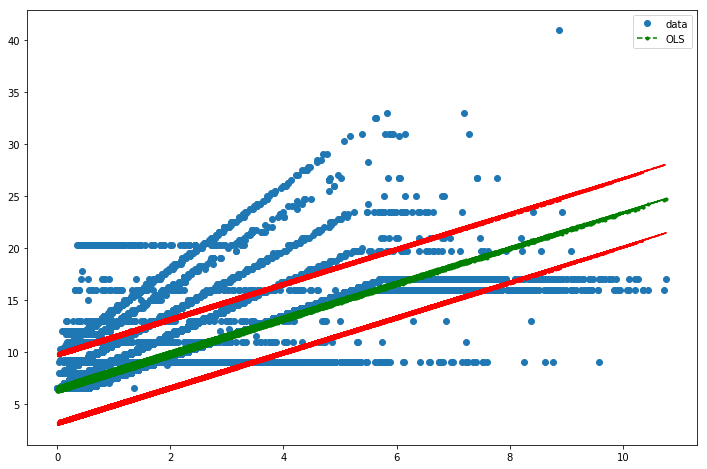

In [63]:
# predictor variable (x) and dependent variable (y)
x = df[['distance_pickup_to_dropoff_km']]
y = df[['delivery_price']]

# Retrieve our confidence interval values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(delivery_model)

fig, ax = plt.subplots(figsize=(12,8))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x, y, 'o', label="data")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x, delivery_model.fittedvalues, 'g--.', label="OLS")

# plot upper and lower ci values
ax.plot(x, confidence_interval_upper, 'r--')
ax.plot(x, confidence_interval_lower, 'r--')

# plot legend
ax.legend(loc='best')

### Vehicle Type Analysis

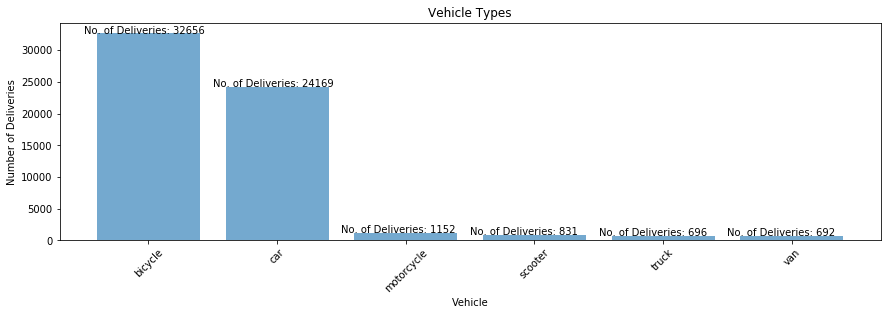

In [64]:
df_vehicle = raw_data.groupby(['vehicle_type']).count()['customer_price_usd']
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(the_grid[0])
ax1.bar(df_vehicle.index, df_vehicle.values, color = '#74a9cf')
plt.xticks(rotation=45)
#plt.xticks(range(24))
#ax1.set_xlim(xmax = 23)
plt.title('Vehicle Types')
plt.ylabel('Number of Deliveries')
plt.xlabel('Vehicle')
for i, v in enumerate(df_vehicle.values):
    plt.text(i - 0.5, v , 'No. of Deliveries: ' + str(v))

- We have six types of vehicles: Bicycle, Car, Motorcycle, Scooter, Truck and van. Bicycle is most used vehicle for deliveries among these types.

In [65]:
df = df[df['avg_courier_rating'] != 'None']
df['avg_rating'] = df.avg_courier_rating.astype('float')

In [66]:
df_vehicle_rating = df.groupby(['vehicle_type']).mean()['avg_rating']

In [67]:
df_vehicle_rating

vehicle_type
bicycle       4.849458
car           4.828594
motorcycle    4.820806
scooter       4.838854
truck         4.842496
van           4.756231
Name: avg_rating, dtype: float64

- We calculate average rating group by each vehicle type where we can see that bicycle has the highest rating by customers which is about 4.849.

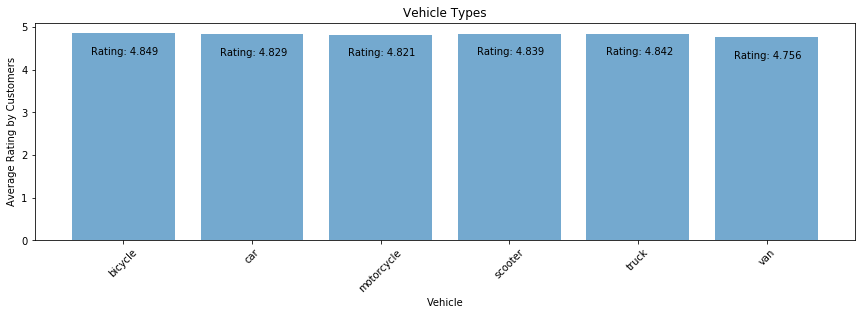

In [68]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(the_grid[0])
ax1.bar(df_vehicle_rating.index, df_vehicle_rating.values, color = '#74a9cf')

plt.xticks(rotation=45)

plt.title('Vehicle Types')
plt.ylabel('Average Rating by Customers')
plt.xlabel('Vehicle')
for i, v in enumerate(df_vehicle_rating.values):
    plt.text(i - 0.25, v - 0.5, 'Rating: ' + str(round(v,3)))

In [69]:
df['profit'] =  df['delivery_price'] - df['courier_price']
df_vehicle_profit = df[df['courier_price'] != np.inf].groupby(['vehicle_type']).mean()['profit']
df_vehicle_profit

vehicle_type
bicycle       2.917878
car           2.823906
motorcycle    2.866495
scooter       2.752677
truck         2.865592
van           2.727310
Name: profit, dtype: float64

- Bicycle also has the highest average profit which is about $2.92.

### Summary
#### Data Integrity Issues
When cleaning the data, I found two main issues:

- Data Type Issues:
I need to convert zip code, customer_price_usd, date_created_local, duration data types to make them suitable for further analysis. During the analysis process, some data are missing or have inf numbers which need to be considered. 

- Data Outlier Issues:
Additionally, some outliers in delivery time could be potentially suspicious and wrong data which lead to unambiguous results. By identifying outliers, we could look into more with unusual delivery time orders in the future to find the reasons for being delivered late.


#### Data Analysis
- Number of Deliveries: 
Overall the number of deliveries we have completed has gone up through the month of March, April and May. As each week progresses, we see the number of deliveries increase, take a drop on weekdays and a small peak on Wednesday in the mid of the week, and then a largest peak on Sundays.
On both weekdays and weekends, deliveries first peak at around midnight time. However on the weekdays, deliveries slow down again until dinner while on the weekends, deliveries remain constant until they peak around dinner. On both weekdays and weekends we see the most number of orders occur around dinner. We want to make sure we have enough couriers to respond to these orders during peak midnight and dinner times.


- Average Delivery Times: Overall, delivery times have stayed consistent through the month, despite having an increasing number of deliveries. Our average delivery time for the month has been 43 minutes. However I have found a number of deliveries that took much longer and should be investigated further to better understand how we may improve our operations. As the number of deliveries increases through the week, our average delivery time increases as well. This could be because we do not have enough couriers during these peak times to respond quickly enough to the orders. We may want to look into either hiring more couriers during peak times or provide a better incentive to have our couriers work during these times.



Most popular 10 pickup locations include: 
- Inner Mission/Bernal Heights               8404
- South of Market                            6651
- Marina                                     6304
- Polk/Russian Hill (Nob Hill)               5481
- Western Addition/Japantown                 4208
- Hayes Valley/Tenderloin/North of Market    3915
- Haight-Ashbury                             3540
- Potrero Hill                               3367
- Castro/Noe Valley                          3085
- North Beach/Chinatown                      1748

Most popular 10 dropoff locations include:
- Polk/Russian Hill (Nob Hill)               5885
- South of Market                            5284
- Inner Mission/Bernal Heights               5164
- Potrero Hill                               4952
- Marina                                     4889
- Mission District                           4695
- Haight-Ashbury                             4051
- Western Addition/Japantown                 3697
- Castro/Noe Valley                          3556
- Hayes Valley/Tenderloin/North of Market    2486

We could see Chinatown is included in most popular pickup locations while not in most popular dropoff locations. This may due to that for example there are many popular choices and stores, restaurants in Chinatown but not so many people order deliveries in this area.
The most popular delivery route is pick-up at Marina and drop-off at Marina, the second popular one is pick-up at Marina and drop-off at Inner Mission/Bernal Heights.
We should make sure we have more couriers delivering along these popular routes.   

- Vehicle Types:
We have six types of vehicles: bicycle, car, motorcycle, scooter, truck and van.
From the graph we could tell the most used vehicle is bicycle, additionally bicycle has the highest average rating and shortest delivery time. It appears that bicycle is a better choice for our delivery service. 
We could also make some shared bicycle spots along the most popular routes. Registered courier could use the bicycles and return them back to certain spots after delivering orders. It will shorten time for courier to pick up orders and provide convenience for them.
Most orders have viable distance which makes bicycle a viable, zero-gasoline proposition for couriers. And it can avoid traffic issues for timely delivery service.